# Data Science Task: Signal Processing

#### This notebook implements code cells to address given tasks as follows.
####    1- Reading the ECG files and corresponding annotations
####     2- Visualizing signals in appropriate manner to be read by a doctor
####     3- Identifing the heart beat of the signal, average and total heart beat in the signal
####     4- Identifing the complex QRS in the signal and been able to annotate on it



This notebook is based on the package named "NeuroKit2". The repository of this package can be found in the address https://github.com/neuropsychology/NeuroKit. This package provides easy access to advanced biosignal processing routines. One of the reasons we used this package is that the majority of the signal processing community uses it. The repository at https://github.com/obss/BIOBSS provides a table of existing packages and highlights the features that each package has. Looking at the repository of NeuroKit2, we can see it has 1.5k stars, which shows it is a commonly used package.

In the following sections, we explain each cell.


In this cell, we specify the address for the data as well as the CSV file containing the metadata of the dataset. Also, we have reused some codes from a python file exist in dataset to add labels of signal to the data frame  $metadata\_dataframe$ .

In [1]:
import pandas as pd
import ast

data_path = './data/'
metadata_dataframe = pd.read_csv('ptbxl_database.csv')
metadata_dataframe.scp_codes = metadata_dataframe.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
metadata_dataframe['diagnostic_superclass'] = metadata_dataframe.scp_codes.apply(aggregate_diagnostic)

We are going to visualize the signals and highlight some of their features. According to the provided metadata, each signal sample has the following features:

1- $Sample\_rate$, which is 500Hz (records500/) and its downsampled versions at a sampling frequency of 100Hz (records100/). We determine this feature with the variable "sampling_rate".

2- Each signal sample has an identical ID indicated by the $ecg\_id$ variable in the code.

3- Each signal is recorded from a specific source specified by $lead\_index$.

The user can change the values of these three variables and see the results for different signals from different people recorded from different sources.

At the end of the cells, we check the values set for the variables. These are set based on the information provided in the dataset.

In [2]:
sampling_rate = 500
ecg_id = 5
lead_index = 0

assert sampling_rate == 100 or sampling_rate == 500 ,  "Sampling rate must be one of 500 or 100"
assert isinstance(ecg_id, int), "ecg_id should be integer"
assert ecg_id >=1 and ecg_id <=21837, "ecg id should be between in range [1,21837]"
assert isinstance(lead_index, int), "lead_index should be integer"
assert lead_index >=0 and lead_index <=11, "lead_index should be between in range [0,11]"

In the following cell, we read the ECG signal using wfdb library. Moreover, we import the package NeuroKit2. The last line print the label of the signal.

In [3]:
import wfdb
import neurokit2 as nk

if sampling_rate == 100:
    ecg_file_name = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'filename_lr'].values[0]
    ecg_label = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'diagnostic_superclass']
    data = wfdb.rdsamp(data_path+ecg_file_name)[0]
elif sampling_rate == 500:
    ecg_file_name = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'filename_hr'].values[0]
    ecg_label = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'diagnostic_superclass']
    data = wfdb.rdsamp(data_path+ecg_file_name)[0]

print('label: ',ecg_label)


label:  4    [NORM]
Name: diagnostic_superclass, dtype: object


In the following cells, we create a DataFrame of 12-lead ECG records of 10 seconds. The shape of the output is (1000, 12), where 1000 indicates the signal length and 12 indicates the number of sources recording the signals. We plot each signal individually, and the legend of each plot shows the index of the lead.

The functions $ecg\_plot$ and $signal\_plot$ from Neurokit2 were rendereing in wrong sizes. So, I reued these functions, made some minor modifications to resolve these issues and have my own myplot.py. 


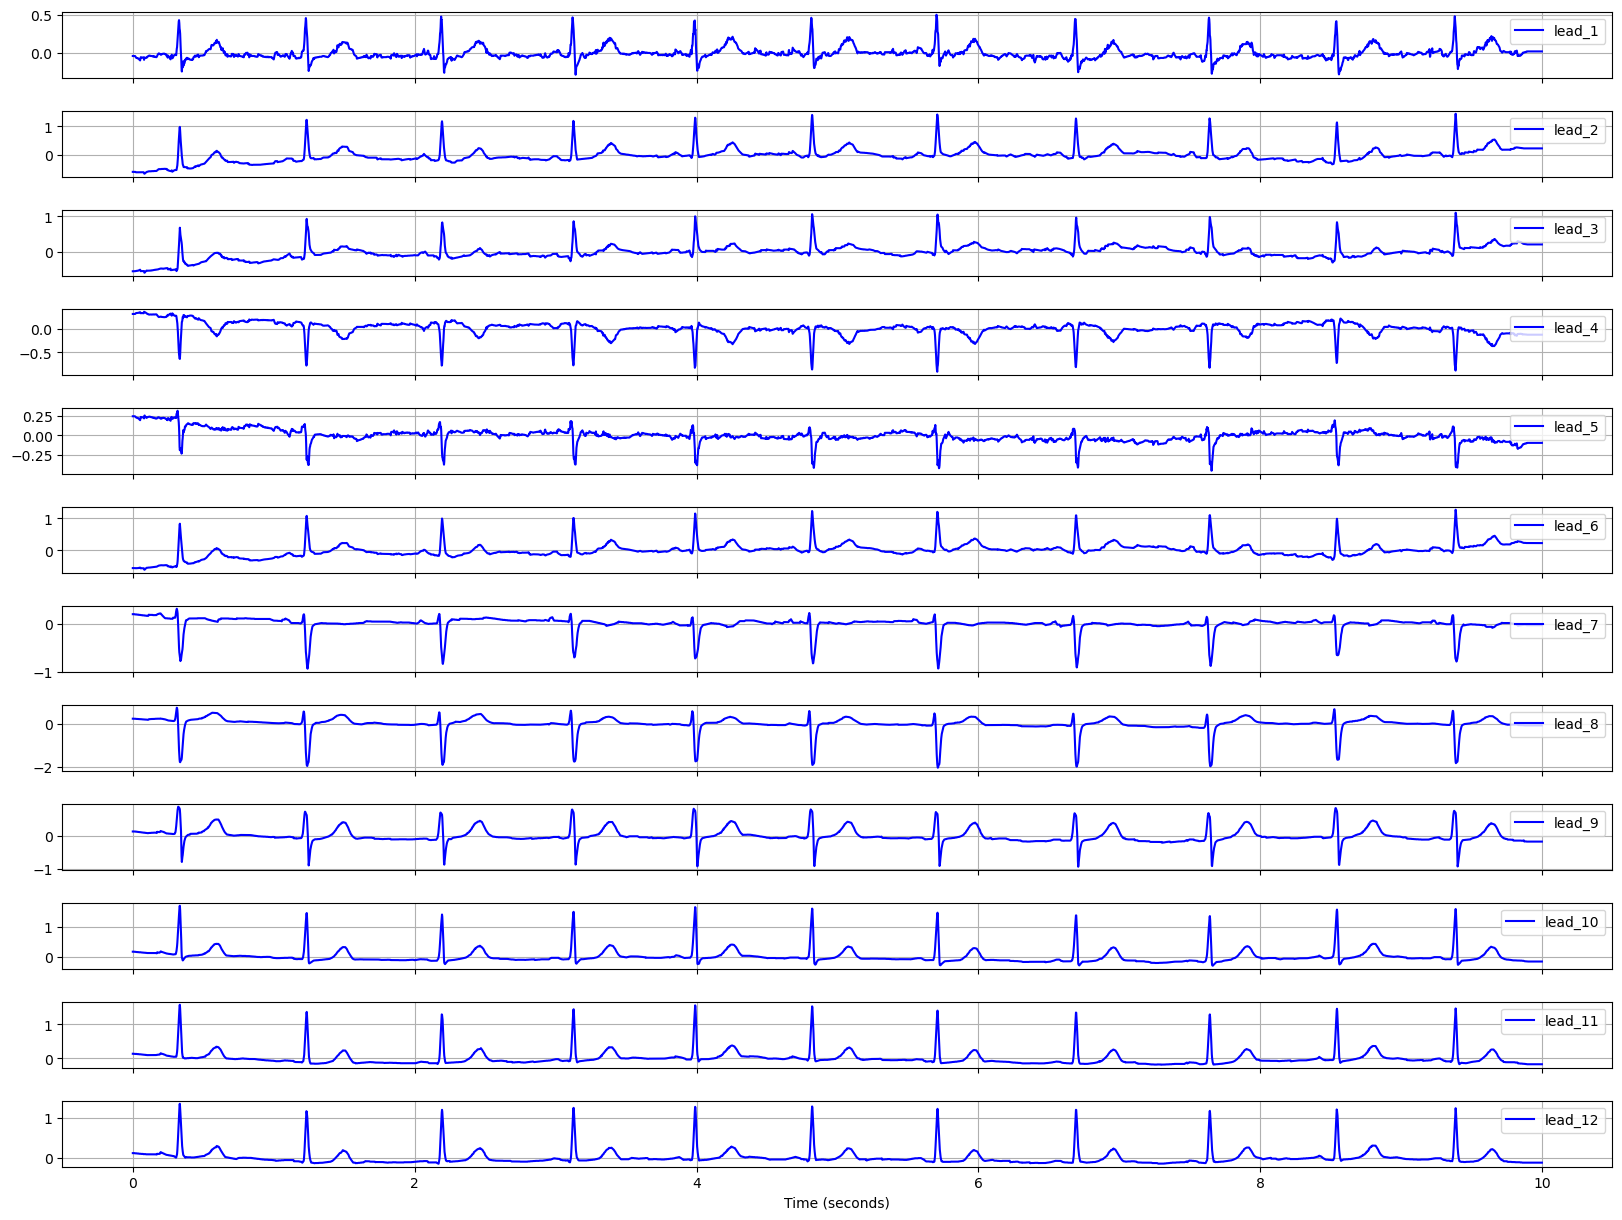

In [4]:
import myplot

all_leadECG_records = pd.DataFrame({"lead_"+str(lead_dim+1): data[:,lead_dim] for lead_dim in range(data.shape[1])})
myplot.signal_plot(all_leadECG_records, sampling_rate = sampling_rate, subplots = True)

We reused the function $ecg\_plot$ from Neurokit2 and solved its rendering issue. This function receives a signal sample from 12 leads and applies various algorithms. As a result, it provides us with three plots as follows:

1- Upper left plot: Shows different versions of the signal for the 10-second period. These include raw and cleaned signals. The R-peaks are annotated by yellow circles.

2- Upper right plot: Illustrates the average heartbeat. The average value is shown in the title of the plot. Moreover, this plot highlights the QRS complex in the signal.

3- Lower left plot: Illustrates the heart rate of the signal.

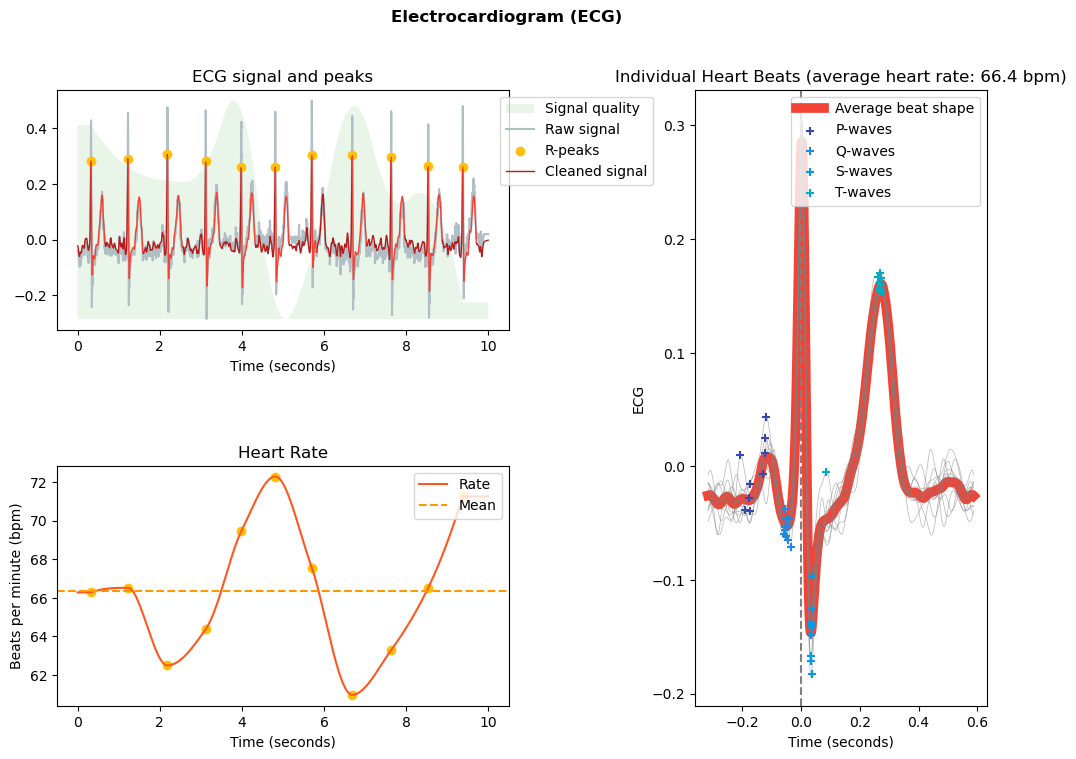

In [5]:
ecg = data[:,lead_index]
# Process it
signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
# Visualise the processing
myplot.ecg_plot(signals, info)